In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15490, done.
remote: Total 15490 (delta 0), reused 0 (delta 0), pack-reused 15490
Receiving objects: 100% (15490/15490), 14.08 MiB | 17.81 MiB/s, done.
Resolving deltas: 100% (10408/10408), done.


In [3]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [8]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2022-09-18 15:06:39--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 108.177.126.101, 108.177.126.102, 108.177.126.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8dd8ccm6s2sc0mlte4i69491npabcas1/1663513575000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=3d08d422-2ad0-4212-a0ec-d583b253ad3f [following]
--2022-09-18 15:06:40--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8dd8ccm6s2sc0mlte4i69491npabcas1/1663513575000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download&uuid=3d08d422-2ad0-4212-a0ec-d583b253ad3f
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 108.177.126.

In [6]:

from darknet import *
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)

def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

# New Section

{'car': [228, 375, 315, 437]}
{'car': [228, 375, 315, 437], 'truck': [285, 390, 212, 313]}
Take 110 units left


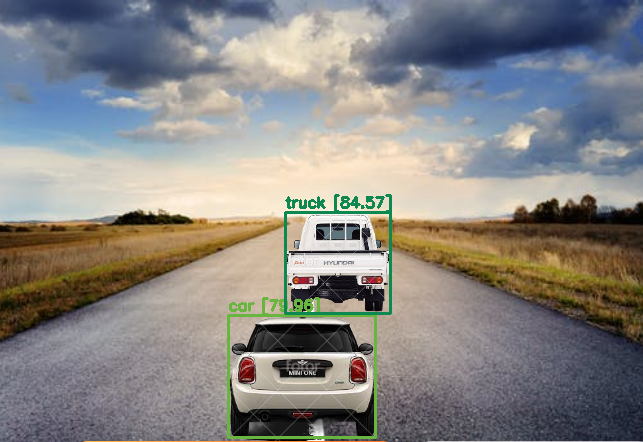

In [9]:
image = cv2.imread("/content/right.png")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
value={}

for label, confidence, bbox in detections:
  l=[]
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  l.append(left)
  l.append(right)
  l.append(top)
  l.append(bottom)
  value[label]=l
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)

if(value['car'][1]<270 and value['truck'][1]<270):
  a=value['truck'][1]
  b=value['car'][0]
  c=a-b
  print("Take",c+20,"units right")
elif(value['car'][0]>260 and value['truck'][0]>260):
  a=value['truck'][0]
  b=value['car'][1]
  c=b-a
  print("Take",c+20,"units left")
elif(value['car'][0]<260 and value['car'][1]>260):
  if(value['truck'][1]>value['car'][0] and value['truck'][1]<value['car'][1]):
    a=value['truck'][1]
    b=value['car'][0]
    c=a-b
    print("Take",c+20,"units right")
  if(value['truck'][0]>value['car'][0] and value['truck'][0]<value['car'][1]):
    a=value['truck'][0]
    b=value['car'][1]
    c=b-a
    print("Take",c+20,"units left")
else:
  print("Slow Down")
  




cv2_imshow(image)